In [0]:
import sys
sys.version

%reset -f
import os
os.environ['PATH'] += ':/usr/local/cuda/bin'
import sys
sys.version

!pip3 install 'torch==0.4.0'
!pip3 install 'torchvision==0.2.1'
!pip3 install --no-cache-dir -I 'pillow==5.1.0'
!pip3 install torchvision
!pip install 'livelossplot==0.2.2'
!pip install 'imageio==2.4.1'

print('done')
# Restart Kernel
# This workaround is needed to properly upgrade PIL on Google Colab.
import os
os._exit(0)

    100% |████████████████████████████████| 484.0MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5c124000 @  0x7f9bffe6b2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 4.8MB/s 
    100% |████████████████████████████████| 2.0MB 14.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 2.0MB 35.1MB/s 


In [2]:
from torch.utils.data import Dataset
from skimage import io, transform
from torch.utils.data import Dataset
import os
import pandas as pd
from PIL import Image
import random 
import numpy as np
from torchvision import transforms, datasets
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
# from scipy.misc import imread 
from imageio import imread
import torch
from livelossplot import PlotLosses


Using TensorFlow backend.


In [3]:

print('__pyTorch VERSION:', torch.__version__)
use_cuda = torch.cuda.is_available()
print('use_cuda = {0}'.format(use_cuda))

DATA_FOLDER ='data'

SEED = 999

def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

fixSeed(SEED)

__pyTorch VERSION: 0.4.0
use_cuda = True


In [4]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"gabib3b","key":"47a6ef15f64b324b1ecb96ea73bf1df7"}'}

In [0]:
!cp kaggle.json ~/.kaggle/


In [8]:
!kaggle datasets download -d vbookshelf/v2-plant-seedlings-dataset

 99% 1.58G/1.59G [00:26<00:00, 47.5MB/s]
100% 1.59G/1.59G [00:26<00:00, 63.5MB/s]


In [0]:

!unzip -q v2-plant-seedlings-dataset.zip -d data

In [5]:
!ls data

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherd’s Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [0]:
input_size = 28 * 28 * 3 
hidden_size = 500  
num_classes = 12  
num_epochs = 50  
batch_size = 100 
learning_rate = 0.001


In [0]:
class DatasetLoader(Dataset):

    def __init__(self, df, transform):
        self._df = df
        self._transform = transform


    @staticmethod
    def find_classes(root_dir):

        labels_folders = os.listdir(root_dir)
        class_to_idx = {}
        xs = []
        ys = []

        for index, label in enumerate(labels_folders):
            class_to_idx[label] = index
            y_train_folder = os.path.join(root_dir, label)
            for file in os.listdir(y_train_folder):
                train_example_path = os.path.join(y_train_folder, file)
                xs.append([train_example_path, label, index])
                ys.append(index)

        df = pd.DataFrame(xs, columns=['file', 'category', 'category_id'])

        return  class_to_idx, df


    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):
        current_element = self._df.iloc[idx]
        fullname = current_element['file']

        image = Image.open(fullname).convert('RGB')

        if self._transform:
            image = self._transform(image)

        label = current_element['category_id']

        return image, label

In [9]:
class_to_idx, data_df = DatasetLoader.find_classes(DATA_FOLDER)
len(data_df)

5539

In [0]:
#train_data = data_df 
train_data = data_df.sample(frac=0.80)
valid_data = data_df[~data_df['file'].isin(train_data['file'])]
from imageio import imread

r_chanel = 0.0
g_chanel = 0.0
b_chanel = 0.0


size = 0.0
for index, row in train_data.iterrows():
    image_path = row['file']

    img = imread(image_path)

    size += img.shape[0] * img.shape[1]
    r_chanel += np.sum(img[:,:, 0])
    g_chanel += np.sum(img[:, :, 1])
    b_chanel += np.sum(img[:, :, 2])

r_mean = r_chanel /size
g_mean = g_chanel /size
b_mean = b_chanel /size

mean_calc_r = 0.0
mean_calc_g = 0.0
mean_calc_b = 0.0

for index, row in train_data.iterrows():
    img = imread(image_path)

    mean_calc_r += np.sum(np.sqrt(np.square(img[:, :, 0] - r_mean)))
    mean_calc_g += np.sum(np.sqrt(np.square(img[:, :, 1] - g_mean)))
    mean_calc_b += np.sum(np.sqrt(np.square(img[:, :, 2] - b_mean)))


std_r = mean_calc_r/(size-1)
std_g = mean_calc_g/(size-1)
std_b = mean_calc_b/(size-1)

mean_rgb = np.asarray([mean_calc_r, mean_calc_g, mean_calc_g])
std_rgb = np.asarray([std_r, std_g, std_b])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


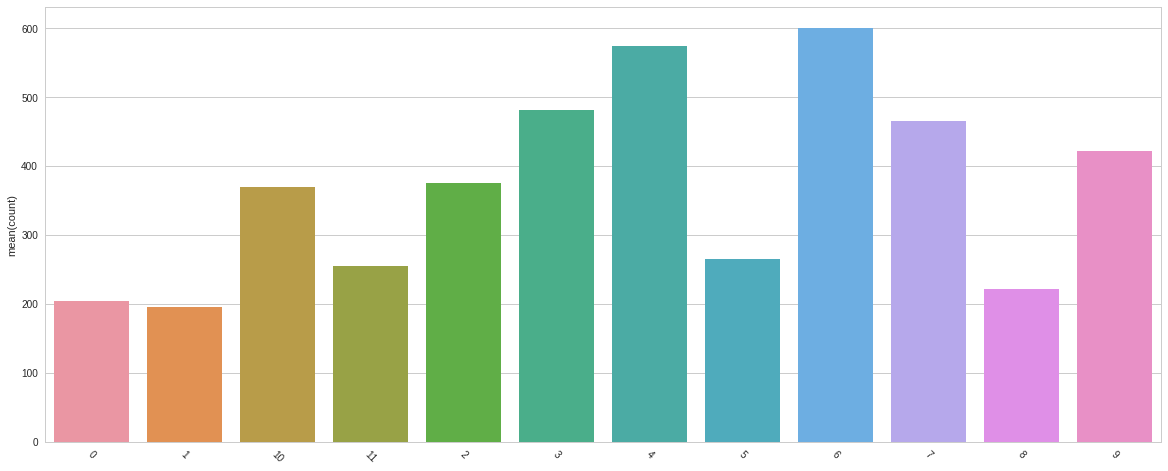

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

# labels = train_data['category_id'].apply(lambda x: x.split(' '))
labels = train_data['category_id'].apply(lambda x: [str(x)])
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(20,8)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-45);

In [0]:
class NetA(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NetA, self).__init__()  # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
        self.relu = nn.ReLU()  # Non-Linear ReLU Layer: max(0,x)
        self.fc2 = nn.Linear(hidden_size,
                             num_classes)  # 2nd Full-Connected Layer: 500 (hidden node) -> 10 (output class)

    def forward(self, x):  # Forward pass: stacking each layer together
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
            


In [27]:
from torch.utils.data import Dataset, DataLoader

print([mean_calc_r, mean_calc_g, mean_calc_g])
print([std_r, std_g, std_b])



normalize_img = transforms.Normalize(mean=[mean_calc_r, mean_calc_g, mean_calc_g],
                                     std=[std_r, std_g, std_b])




train_data_transform = transforms.Compose([
    transforms.Resize(size=(28,28)),
    transforms.ToTensor()#,
    normalize_img
    ])


valid_data_transform = transforms.Compose([
    transforms.Resize(size=(28,28)),
    transforms.ToTensor() #,
    normalize_img
    ])


#todo: split!!!!
train_set = DatasetLoader(train_data, train_data_transform)
valid_set = DatasetLoader(valid_data, valid_data_transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)

print(num_classes)
print(input_size)


[954177797.9213679, 1254773427.980967, 1254773427.980967]
[1.020621880645238, 1.3421494596074668, 1.5639734647812877]
12
2352


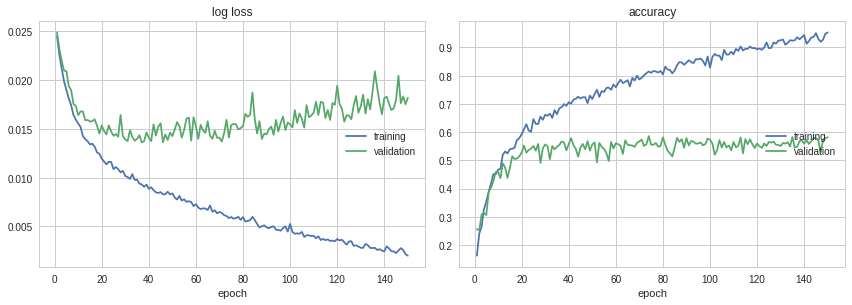

log loss:
training   (min:    0.002, max:    0.024, cur:    0.002)
validation (min:    0.014, max:    0.025, cur:    0.018)

accuracy:
training   (min:    0.162, max:    0.953, cur:    0.953)
validation (min:    0.252, max:    0.586, cur:    0.581)


In [40]:

liveloss = PlotLosses()


neta = NetA(input_size, hidden_size, num_classes)


print(neta)
if use_cuda:
    print('use coda')
    model = neta.cuda()
else:
    print('dont use coda')
    model = neta

model = torch.nn.DataParallel(model, device_ids=list(range(1)))    

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
learning_rate=0.001
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

if use_cuda:
  criterion.cuda()

print('use_cuda {0}'.format(use_cuda))
model.train()
num_epochs = 150
print('b1')

for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    epoch_correct = 0.0
    epoch_incorrect = 0.0
    epoch_loss_val = 0.0
    epoch_correct_val = 0.0
    avg_loss_val = 0.0
    avg_accuracy_val = 0.0
    model.train()
    total = 0.0
    correct = 0.0
    for i, (images, labels) in enumerate(train_loader):  # Load a batch of images with its (index, data, class)
       
        if use_cuda and torch.cuda.is_available():
            images = images.view(-1, 28 * 28 * 3).cuda()
            labels = labels.cuda()
            images = Variable(images)  
            labels = Variable(labels)
        else:
          images = Variable(images.view(-1, 28 * 28 * 3))  
          labels = Variable(labels)
        
        optimizer.zero_grad()    
        
        outputs = model(images)  
        loss = criterion(outputs, labels)
        
        
        loss.backward() 
        optimizer.step()
        
        running_loss = loss.item()
        print(' running_loss = {0}'.format(running_loss))
        
        total += len(images)
        
        epoch_loss += loss.data[0]
        current_correct = (outputs.data.cpu().max(1)[1] == labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
        current_incorrect = (outputs.data.cpu().max(1)[1] != labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
        epoch_incorrect += current_incorrect
        
        
        pred = outputs.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(labels.data).cpu().sum()
        accuracy = 100. * correct / len(images)
        #print('accuracy = {0}'.format(accuracy))
        
#         print(outputs.data.cpu().max(1)[1])
#         print(labels.cpu())
        
        #print('current_correct = {0}'.format(current_correct))
        epoch_correct += current_correct
        
    avg_loss = epoch_loss / len(train_loader.dataset)
    avg_accuracy = epoch_correct / (len(train_loader.dataset)*1.0)
    
    print('total = {0}'.format(total))
    print('avg_accuracy = {0}'.format(avg_accuracy))
    print('epoch_correct = {0} len(train_loader.dataset)={1} epoch_incorrect ={2}'.format(epoch_correct, len(train_loader.dataset), epoch_incorrect))
    
    model.eval()
    for inputs, labels in validation_loader:
                
        if use_cuda and torch.cuda.is_available():
            inputs = inputs.view(-1, 28 * 28 * 3).cuda()
            labels = labels.cuda()
            inputs = Variable(inputs)  
            labels = Variable(labels)
        else:
          inputs, labels = Variable(inputs.view(-1, 28 * 28 * 3)) , Variable(labels)
        
   
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        
        epoch_loss_val += loss.data[0]
        
        
        epoch_correct_val += (outputs.cpu().data.max(1)[1] == labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
    
    #print('epoch_correct_val = {0}'.format(epoch_correct_val))
    
    avg_loss_val = epoch_loss_val / len(validation_loader.dataset)
    avg_accuracy_val = epoch_correct_val / len(validation_loader.dataset)
    
    #print('avg_accuracy_val = {0}'.format(avg_accuracy_val))
    
    liveloss.update({
        'log loss': avg_loss,
        'val_log loss': avg_loss_val,
        'accuracy': avg_accuracy,
        'val_accuracy': avg_accuracy_val
    })
    
    liveloss.draw()
    
    
        

In [0]:
#@title Example form fields
#@markdown Forms support many types of fields.

no_type_checking = ''  #@param
string_type = 'example'  #@param {type: "string"}
slider_value = 142  #@param {type: "slider", min: 100, max: 200}
number = 102  #@param {type: "number"}
date = '2010-11-05'  #@param {type: "date"}
pick_me = "monday"  #@param ['monday', 'tuesday', 'wednesday', 'thursday']
select_or_input = "apples" #@param ["apples", "bananas", "oranges"] {allow-input: true}
#@markdown ---


In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))